In [1]:

import streamlit as st
import pandas as pd
from datetime import date
import numpy as np
import time
from pystac_client import Client
from shapely import geometry 
import rioxarray
import requests
import matplotlib.pyplot as plt
import sys

from datetime import datetime
from google.cloud import storage
import json
import utm
import math
from PIL import Image
from rasterio.plot import show
import rasterio
import boto3
import rasterio.features
import rasterio.warp
from rasterio.session import AWSSession
from rasterio.enums import Resampling


In [2]:
## PARAMS

max_items = 100
cloud_cover = 95
start_date = '2019-12-21'
end_date = '2023-02-27'
lon = -73.27
lat = -8.52

In [3]:
## Key areas
# Descripción	Zona	x	y
z1 = {
    'name': 'Alto_Tamaya', 
    'zone' : 18, 
    'zone_sec' : 'L' , 
    'x' : 692383.15 , 
    'y' : 8948382.16
}

z2 = {
    'name': 'Shatanya', 
    'zone' : 18, 
    'zone_sec' : 'L' , 
    'x' : 672565.99 , 
    'y' : 8948378.74
}

z3 = {
    'name': 'Sheshea', 
    'zone' : 18, 
    'zone_sec' : 'L' , 
    'x' : 657978.43 , 
    'y' : 8941360.62
}


z4 = {
    'name': 'Sawawo_Hito_40', 
    'zone' : 18, 
    'zone_sec' : 'L' , 
    'x' : 691747.52, 
    'y' : 8943552.64
}

z5 = {
    'name': 'Luzeiro', 
    'zone' : 18, 
    'zone_sec' : 'M' , 
    'x' : 746000.268, 
    'y' : 9135624.147
}


zone = z5


In [4]:
lat, lon = utm.to_latlon(zone['x'], zone['y'], zone['zone'], zone['zone_sec'])

In [5]:
zone

{'name': 'Luzeiro',
 'zone': 18,
 'zone_sec': 'M',
 'x': 746000.268,
 'y': 9135624.147}

In [6]:
# Set up the GCP project and bucket information
project_id = 'amazon-377618'
bucket_name = 'peru_chips'

# Create a client to interact with the bucket
client = storage.Client(project=project_id)

# Get the bucket you want to save the dictionary to
bucket = client.bucket(bucket_name)

In [7]:
def aws_sentinel_retrieve_item(max_items,start_date,end_date,zone, cloud_cover=50):
    
    lat, lon = utm.to_latlon(zone['x'], zone['y'], zone['zone'], zone['zone_sec'])
    
    search = Client.open("https://earth-search.aws.element84.com/v0").search(
        collections=["sentinel-s2-l2a-cogs"],
        intersects=geometry.Point(lon,lat),
        max_items=max_items,
        datetime=f"{start_date}/{end_date}",
        query=[f"eo:cloud_cover<{cloud_cover}"]
    )

    # create dataframe with main metadata and thumbnails

    if search.matched() < 1:
        return 'failed'
    
    items = search.get_all_items()
    
#     item = items[pd.DataFrame(data = {'cloud_cover' : [item.properties['eo:cloud_cover'] for item in items]}).sort_values(by='cloud_cover').index[0]]
    
#     del items

    return items

In [8]:
def chipping(mosaic,chip_coord):
#     print(chip_coord)
    
    return mosaic[
        int(chip_coord['x_top_left_px']):int(chip_coord['x_bottom_right_px']),
        int(chip_coord['y_top_left_px']):int(chip_coord['y_bottom_right_px'])
    ]


In [9]:
def chiping_list(mosaic_shape,mosaic_geom,dist,overlap):
    
    # calculate longitudes of top left corner    
    vec_x = int((1-overlap)*dist)*np.arange(0,int(mosaic_shape[1]//int((1-overlap)*dist)),1)
    vec_x[-1] = mosaic_shape[1]-dist

    # calculate latitudes of top left corner
    vec_y = int((1-overlap)*dist)*np.arange(0,int(mosaic_shape[2]//int((1-overlap)*dist)),1)    
    vec_y[-1] = mosaic_shape[2]-dist

    # create the data frame with longitude and latitude of both corners of the chip
    chip_df = pd.DataFrame(data=np.array(np.meshgrid(vec_x,vec_y)).T.reshape(len(vec_x)*len(vec_y),2), 
                           columns=['x_top_left_px', 'y_top_left_px'])

    chip_df['x_bottom_right_px'] = chip_df.apply(lambda x: x['x_top_left_px']+dist , axis=1)
    chip_df['y_bottom_right_px'] = chip_df.apply(lambda x: x['y_top_left_px']+dist , axis=1)
    
    max_lon = max([item[0] for item in item.geometry['coordinates'][0]])
    min_lon = min([item[0] for item in item.geometry['coordinates'][0]])
    
    max_lat = max([item[1] for item in item.geometry['coordinates'][0]])
    min_lat = min([item[1] for item in item.geometry['coordinates'][0]])
    
    x_top_left_utm, y_top_left_utm, zone_top_left, zone_sec_top_left = utm.from_latlon(max_lat, min_lon)
    x_bottom_right_utm, y_bottom_right_utm, zone_top_left, zone_sec_top_left = utm.from_latlon(min_lat, max_lon)
    
    
    chip_df['x_top_left_utm'] = chip_df.apply(lambda x: x['x_top_left_px']*10 +  x_top_left_utm, axis=1)
    chip_df['y_top_left_utm'] = chip_df.apply(lambda x: - x['y_top_left_px']*10 +  y_top_left_utm, axis=1)
    
    chip_df['x_bottom_right_utm'] = chip_df.apply(lambda x: x['x_bottom_right_px']*10 +  x_top_left_utm, axis=1)
    chip_df['y_bottom_right_utm'] = chip_df.apply(lambda x: - x['y_bottom_right_px']*10 +  y_top_left_utm, axis=1)
    
    
    return chip_df





In [10]:
# chip_list_df = chiping_list(mosaic_red.shape,item.geometry['coordinates'][0],256,0.3)

In [11]:
# chip_list_df.tail()

In [12]:
# chip_list_df[(chip_list_df['x_top_left_utm'] <= zone['x']) 
#              & (zone['x'] <= chip_list_df['x_bottom_right_utm'])
#              & (chip_list_df['y_top_left_utm'] >= zone['y']) 
#              & (zone['y'] >= chip_list_df['y_bottom_right_utm'])]

In [13]:
def scale_values(values):
    # Get the minimum and maximum values
    
    # min_value = np.min(values)
    # max_value = np.max(values)
    
    min_value = 10
    max_value = 1000
    
    # if max_value > 5000:
    #     max_value = 5000
    
    # Calculate the range of the values
    value_range = max_value - min_value
    # Scale the values to a range of 0 to 1
    scaled_values = np.array([255*((value - min_value) / value_range) for value in values]).astype(int)
    scaled_values = np.where(scaled_values >= 255, 255, scaled_values)
    scaled_values = np.where(scaled_values < 0, 0, scaled_values)

    return  scaled_values

In [14]:
def download_mosaic_rgb(item):
    
    mosaic_red = rioxarray.open_rasterio(item.assets["B04"].href).values
    mosaic_green = rioxarray.open_rasterio(item.assets["B03"].href).values
    mosaic_blue = rioxarray.open_rasterio(item.assets["B02"].href).values
    
    return mosaic_red, mosaic_green, mosaic_blue

In [15]:
def send_to_bucket(rgb_chip,mosaic_rgb,date_str,i,blob_desc = [],file_desc = [], to_thumbnail = 0):
     
    if blob_desc != []:
        date_str = blob_desc +'/' +date_str
        
    if file_desc != []:
        i = file_desc +'_' +str(i)
    
    # Set the name of the file to save in the bucket
    filename = f'{date_str}/{i}'  
    
    if to_thumbnail == 1:
        
        start_thumb = time.time()
        
        # create a blob (i.e., a file) in the bucket with the name 'thumbnail.jpg'
        blob = bucket.blob(f"{filename}.jpg")

        # create the thumbnail and save it to a file
        img_thumb = Image.fromarray(np.array(mosaic_rgb).astype(np.uint8))
        img_thumb.thumbnail((len(mosaic_rgb), len(mosaic_rgb[0])))
        img_thumb.save(f"dump.jpg", 'JPEG')

        # upload the thumbnail file to the bucket
        with open(f"dump.jpg", 'rb') as f:
            blob.upload_from_file(f)

        # get the URL of the thumbnail file in the bucket
        thumbnail_url = blob.public_url        
        
        rgb_chip['thumbnail'] = thumbnail_url
        
        print(f'time for thumbnail : {time.time() - start_thumb}')
        
        
        
    # Convert dictionary to JSON format
    json_data = json.dumps(rgb_chip)

    
    del rgb_chip  
    
    # Create a blob object to save the file to the bucket
    blob = bucket.blob(f"{filename}.json")

    # Upload the JSON data to the blob object
    blob.upload_from_string(json_data)
    

In [16]:
def aws_sentinel_chip(item,zone,scale_option = 0, to_bucket = 0,to_thumbnail = 0, blob_desc=[],file_desc=[]):
# def aws_sentinel_chip(item,zone,mosaic_red,mosaic_green,mosaic_blue,to_bucket = 0,blob_desc=[],file_desc=[]):    

#     zone['x'], zone['y'], zone['zone'], zone['zone_sec']
#     ind_item = pick_chip(item.geometry['coordinates'][0])
    
    # Merge each colour band independently and group them into a RGB array
    print(f"date : {item.datetime.strftime('%d/%m/%Y').replace('/','-')}")

    start = time.time()
    
    mosaic_red, mosaic_green, mosaic_blue = download_mosaic_rgb(item)

#     mosaic_red = rioxarray.open_rasterio(item.assets["B04"].href).values
#     mosaic_green = rioxarray.open_rasterio(item.assets["B03"].href).values
#     mosaic_blue = rioxarray.open_rasterio(item.assets["B02"].href).values
    
    print(f'download pics : {time.time()-start}')
    
    start = time.time()
    
    chip_list_df = chiping_list(mosaic_red.shape,item.geometry['coordinates'][0],85,0.3)
    
    print(f'size of chip_list : {chip_list_df.shape}')
    
    print(f'chipping list : {time.time()-start}')
    
    start_chips = time.time()
    
    rgb_chips_df = {'coordinates' : item.geometry['coordinates'][0]}
    
    chip_list_zone_df  =   chip_list_df[(chip_list_df['x_top_left_utm'] <= zone['x']) 
             & (zone['x'] <= chip_list_df['x_bottom_right_utm'])
             & (chip_list_df['y_top_left_utm'] >= zone['y']) 
             & (zone['y'] >= chip_list_df['y_bottom_right_utm'])]
    
    for i, chip in chip_list_zone_df.iterrows():
        
        start = time.time()
               
        chip_red = chipping(mosaic_red.reshape((mosaic_red.shape[1],mosaic_red.shape[2])),chip)
        chip_green = chipping(mosaic_green.reshape((mosaic_green.shape[1],mosaic_green.shape[2])),chip)
        chip_blue = chipping(mosaic_blue.reshape((mosaic_blue.shape[1],mosaic_blue.shape[2])),chip)
        
        if scale_option == 1:

            chip_red = scale_values(chip_red)
            chip_green = scale_values(chip_green)
            chip_blue = scale_values(chip_blue)


        mosaic_rgb = np.stack([chip_red, 
                               chip_green, 
                               chip_blue], 
                              axis=2)   
        
        if np.min(mosaic_rgb) == 255 and np.mean(mosaic_rgb) == 255:
            print('all white')
            pass
        else:
        
            print('not all white')
        
            y_top_left_gps, x_top_left_gps = utm.to_latlon(chip['x_top_left_utm'], chip['y_top_left_utm'], zone['zone'], zone['zone_sec'])
            y_bottom_right_gps, x_bottom_right_gps = utm.to_latlon(chip['x_bottom_right_utm'], chip['y_bottom_right_utm'], zone['zone'], zone['zone_sec'])

            rgb_chip = { 'pxl' : 
                        {'x_top_left' : chip['x_top_left_px'],
                       'y_top_left' : chip['y_top_left_px'],
                       'x_bottom_right' : chip['x_bottom_right_px'],
                        'y_bottom_right' : chip['y_bottom_right_px']},
                         'utm' : 
                        {'x_top_left' : chip['x_top_left_utm'],
                       'y_top_left' : chip['y_top_left_utm'],
                       'x_bottom_right' : chip['x_bottom_right_utm'],
                        'y_bottom_right' : chip['y_bottom_right_utm']},
                         'gps' : 
                        {'x_top_left' : x_top_left_gps,
                       'y_top_left' : y_top_left_gps,
                       'x_bottom_right' : x_bottom_right_gps,
                        'y_bottom_right' : y_bottom_right_gps}
                       }
#                         ,
#                         'rgb_chip' : mosaic_rgb}
            
            

            # Convert the int64 values to Python ints or strings
            for key, value in rgb_chip.items():

                if isinstance(value, np.ndarray):
                    rgb_chip[key] = value.tolist()
                if isinstance(value, np.int64):
                    rgb_chip[key] = int(value)
                    
#             return rgb_chip
                    
            if to_bucket == 1:
                print('to the bucket')
                send_to_bucket(rgb_chip,
                               mosaic_rgb,
                               item.datetime.strftime("%Y/%m/%d").replace('/','-'),
                               i,
                               blob_desc,
                               file_desc,
                               to_thumbnail)
                

#         rgb_chips_df[i] = rgb_chip
        
        print(f'single chip #{i} : {time.time()-start}')
               

        
    print(f'create chips : {time.time()-start_chips}')
    
#     return rgb_chip
    



# download items


In [17]:
items =  aws_sentinel_retrieve_item(300, start_date,end_date,zone)


In [18]:
for i, item in enumerate(items):
    print(i)
    print(item.datetime.strftime("%Y/%m/%d").replace('/','-'))

0
2023-02-26
1
2023-02-21
2
2023-02-16
3
2023-01-17
4
2022-12-28
5
2022-12-23
6
2022-11-13
7
2022-11-08
8
2022-11-03
9
2022-10-24
10
2022-10-19
11
2022-10-09
12
2022-10-04
13
2022-09-29
14
2022-09-19
15
2022-09-14
16
2022-09-09
17
2022-09-04
18
2022-08-30
19
2022-08-25
20
2022-08-15
21
2022-07-31
22
2022-07-21
23
2022-07-16
24
2022-07-11
25
2022-07-01
26
2022-06-26
27
2022-06-16
28
2022-06-06
29
2022-05-22
30
2022-05-07
31
2022-05-02
32
2022-04-27
33
2022-04-12
34
2022-02-01
35
2022-01-27
36
2022-01-17
37
2022-01-07
38
2021-11-13
39
2021-10-24
40
2021-10-14
41
2021-10-09
42
2021-09-19
43
2021-09-14
44
2021-09-09
45
2021-09-04
46
2021-08-20
47
2021-08-15
48
2021-08-10
49
2021-08-05
50
2021-07-31
51
2021-07-26
52
2021-07-21
53
2021-07-16
54
2021-07-11
55
2021-07-06
56
2021-07-01
57
2021-06-26
58
2021-06-21
59
2021-06-16
60
2021-06-11
61
2021-06-06
62
2021-05-22
63
2021-05-12
64
2021-05-02
65
2021-03-28
66
2021-03-18
67
2021-03-08
68
2021-02-01
69
2021-01-12
70
2021-01-02
71
2020-11-13
72

In [19]:
len(items)

106

In [71]:
# mosaic_red = rioxarray.open_rasterio(items[0].assets["B04"].href).values
# mosaic_green = rioxarray.open_rasterio(items[0].assets["B03"].href).values
# mosaic_blue = rioxarray.open_rasterio(items[0].assets["B02"].href).values

# get small chip

In [ ]:
count = 0
count_break = 4

start_all = time.time()

for item in items:
#     my_dict  = aws_sentinel_chip(item,zone,mosaic_red,mosaic_green,mosaic_blue,to_bucket = 1)
    my_dict  = aws_sentinel_chip(item,
                                 zone,
                                 scale_option = 1, 
                                 to_bucket = 1,
                                 to_thumbnail = 1,
                                 blob_desc = f"85_chips/{zone['name']}"
                                )
       
#     if count == count_break:
#         break
        
    count += 1

    
print(f'total time (s) : {time.time() - start_all} \ntotal time (m) : {(time.time() - start_all)/60}  \ntotal time (h) : {(time.time() - start_all)/3600} ')
    

2023-03-14 09:27:30.401 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


date : 26-02-2023


2023-03-14 09:27:54.324 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:28:16.092 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 67.08565855026245


2023-03-14 09:28:39.209 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.7152822017669678
all white
single chip #22779 : 0.0021712779998779297
all white
single chip #22780 : 0.0020368099212646484
create chips : 0.007431745529174805
date : 21-02-2023


2023-03-14 09:29:00.799 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:29:21.719 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 69.98925471305847
size of chip_list : (34596, 8)
chipping list : 1.6826252937316895
not all white
to the bucket
time for thumbnail : 0.7497849464416504
single chip #22779 : 0.8321866989135742
not all white
to the bucket


2023-03-14 09:29:51.978 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.17881131172180176
single chip #22780 : 0.26149702072143555
create chips : 1.0967612266540527
date : 16-02-2023


2023-03-14 09:30:16.629 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:30:42.163 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 80.76809191703796
size of chip_list : (34596, 8)
chipping list : 2.8334767818450928
not all white
to the bucket
time for thumbnail : 0.17351746559143066
single chip #22779 : 0.2555248737335205
not all white
to the bucket
time for thumbnail : 0.182114839553833


2023-03-14 09:31:16.112 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.26728105545043945
create chips : 0.5294144153594971
date : 11-02-2023


2023-03-14 09:31:35.550 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:31:54.812 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 56.861305475234985
size of chip_list : (34596, 8)
chipping list : 6.398594856262207
not all white
to the bucket
time for thumbnail : 0.1741955280303955
single chip #22779 : 0.2587604522705078
not all white
to the bucket


2023-03-14 09:32:19.927 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.20747017860412598
single chip #22780 : 0.2929997444152832
create chips : 0.5549581050872803
date : 06-02-2023


2023-03-14 09:32:35.684 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:32:49.537 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 43.58872866630554


2023-03-14 09:33:06.411 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.8878400325775146
all white
single chip #22779 : 0.0021271705627441406
all white
single chip #22780 : 0.0020613670349121094
create chips : 0.007128238677978516
date : 27-01-2023


2023-03-14 09:33:31.353 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:33:53.727 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 73.53272843360901
size of chip_list : (34596, 8)
chipping list : 2.228508949279785
not all white
to the bucket
time for thumbnail : 0.30576276779174805
single chip #22779 : 0.38165974617004395
not all white
to the bucket


2023-03-14 09:34:22.845 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.1982557773590088
single chip #22780 : 0.2853567600250244
create chips : 0.6705291271209717
date : 22-01-2023


2023-03-14 09:34:44.778 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:35:08.308 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 66.87026810646057


2023-03-14 09:35:34.600 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 4.836880683898926
all white
single chip #22779 : 0.016067028045654297
all white
single chip #22780 : 0.016833066940307617
create chips : 0.04803276062011719
date : 17-01-2023


2023-03-14 09:35:59.890 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:36:21.205 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 66.05585503578186
size of chip_list : (34596, 8)
chipping list : 2.336717128753662
all white
single chip #22779 : 0.0023589134216308594
not all white
to the bucket
time for thumbnail : 0.18480539321899414


2023-03-14 09:36:43.264 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2647097110748291
create chips : 0.27024412155151367
date : 12-01-2023


2023-03-14 09:37:04.146 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:37:28.701 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 74.75773596763611


2023-03-14 09:38:00.085 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.0540876388549805
all white
single chip #22779 : 0.002204418182373047
all white
single chip #22780 : 0.002576112747192383
create chips : 0.008363962173461914
date : 07-01-2023


2023-03-14 09:38:21.561 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:38:40.797 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 61.64312124252319


2023-03-14 09:39:03.699 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.9613935947418213
all white
single chip #22779 : 0.002199411392211914
all white
single chip #22780 : 0.002071380615234375
create chips : 0.007785320281982422
date : 02-01-2023


2023-03-14 09:40:23.102 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:41:18.123 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 161.39637279510498


2023-03-14 09:41:49.938 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 4.81697678565979
all white
single chip #22779 : 0.006296634674072266
all white
single chip #22780 : 0.011898040771484375
create chips : 0.024756193161010742
date : 28-12-2022


2023-03-14 09:42:13.336 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:42:36.464 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 68.82377409934998


2023-03-14 09:43:00.692 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.920356273651123
all white
single chip #22779 : 0.002365589141845703
all white
single chip #22780 : 0.0022492408752441406
create chips : 0.008809566497802734
date : 23-12-2022


2023-03-14 09:43:24.745 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:43:48.241 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 68.88548064231873
size of chip_list : (34596, 8)
chipping list : 2.4243788719177246
not all white
to the bucket
time for thumbnail : 0.18259596824645996
single chip #22779 : 0.2575113773345947
not all white
to the bucket
time for thumbnail : 0.16600608825683594


2023-03-14 09:44:12.498 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23404169082641602
create chips : 0.4954085350036621
date : 18-12-2022


2023-03-14 09:44:32.978 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:44:54.993 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 61.95103478431702
size of chip_list : (34596, 8)
chipping list : 3.9698843955993652
not all white
to the bucket
time for thumbnail : 0.1663966178894043
single chip #22779 : 0.241851806640625
not all white
to the bucket
time for thumbnail : 0.15622758865356445


2023-03-14 09:45:18.889 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.22389578819274902
create chips : 0.4700126647949219
date : 13-12-2022


2023-03-14 09:45:38.901 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:45:58.855 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 58.24668622016907


2023-03-14 09:46:19.109 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.9656646251678467
all white
single chip #22779 : 0.0021257400512695312
all white
single chip #22780 : 0.002328157424926758
create chips : 0.007573843002319336
date : 08-12-2022


2023-03-14 09:46:53.336 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:47:11.819 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 72.09714865684509


2023-03-14 09:47:33.024 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.8086426258087158
all white
single chip #22779 : 0.002393007278442383
all white
single chip #22780 : 0.0021076202392578125
create chips : 0.008158445358276367
date : 28-11-2022


2023-03-14 09:47:59.107 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:48:31.484 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 83.95655393600464
size of chip_list : (34596, 8)
chipping list : 1.7338874340057373
not all white
to the bucket
time for thumbnail : 0.174513578414917
single chip #22779 : 0.24776911735534668
not all white
to the bucket


2023-03-14 09:48:59.359 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.3087737560272217
single chip #22780 : 0.3786134719848633
create chips : 0.6420743465423584
date : 23-11-2022


2023-03-14 09:49:17.715 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:49:35.631 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 52.13530373573303


2023-03-14 09:49:53.637 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.1338701248168945
all white
single chip #22779 : 0.003536224365234375
all white
single chip #22780 : 0.0021338462829589844
create chips : 0.008912324905395508
date : 18-11-2022


2023-03-14 09:50:12.390 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:50:31.240 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 57.24039840698242
size of chip_list : (34596, 8)
chipping list : 1.7284126281738281
not all white
to the bucket
time for thumbnail : 0.15806126594543457
single chip #22779 : 0.23084688186645508
not all white
to the bucket
time for thumbnail : 0.15021347999572754


2023-03-14 09:50:53.056 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.21482181549072266
create chips : 0.44957423210144043
date : 13-11-2022


2023-03-14 09:51:38.248 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:52:05.224 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 95.35976672172546
size of chip_list : (34596, 8)
chipping list : 1.711611270904541
not all white
to the bucket
time for thumbnail : 0.1645829677581787
single chip #22779 : 0.23346185684204102
not all white
to the bucket
time for thumbnail : 0.17807841300964355


2023-03-14 09:52:30.611 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.24412965774536133
create chips : 0.4809536933898926
date : 08-11-2022


2023-03-14 09:52:57.428 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:53:20.230 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 68.61595606803894
size of chip_list : (34596, 8)
chipping list : 1.7098817825317383
not all white
to the bucket
time for thumbnail : 0.16368484497070312
single chip #22779 : 0.23427200317382812
not all white
to the bucket
time for thumbnail : 0.19373774528503418


2023-03-14 09:53:41.437 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2623097896575928
create chips : 0.5000064373016357
date : 03-11-2022


2023-03-14 09:54:12.110 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:54:32.480 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 69.50709438323975
size of chip_list : (34596, 8)
chipping list : 2.3085200786590576
not all white
to the bucket
time for thumbnail : 0.17510199546813965
single chip #22779 : 0.2466597557067871
not all white
to the bucket
time for thumbnail : 0.15439343452453613


2023-03-14 09:54:53.733 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.22929024696350098
create chips : 0.48023033142089844
date : 29-10-2022


2023-03-14 09:55:09.914 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:55:24.621 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 44.63627362251282


2023-03-14 09:55:40.411 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.0264992713928223
all white
single chip #22779 : 0.004022359848022461
all white
single chip #22780 : 0.004736185073852539
create chips : 0.013587236404418945
date : 24-10-2022


2023-03-14 09:56:02.513 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:56:30.251 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 75.30747628211975
size of chip_list : (34596, 8)
chipping list : 3.5426204204559326
not all white
to the bucket
time for thumbnail : 0.15306973457336426
single chip #22779 : 0.2316277027130127
not all white
to the bucket
time for thumbnail : 0.15986108779907227


2023-03-14 09:56:59.735 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23354554176330566
create chips : 0.4731903076171875
date : 19-10-2022


2023-03-14 09:57:26.185 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:58:05.082 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 87.67937541007996
size of chip_list : (34596, 8)
chipping list : 2.042647361755371
not all white
to the bucket
time for thumbnail : 0.17647957801818848
single chip #22593 : 0.25409626960754395
not all white
to the bucket
time for thumbnail : 0.17917585372924805
single chip #22594 : 0.25762510299682617
not all white
to the bucket
time for thumbnail : 0.16097617149353027
single chip #22779 : 0.23440122604370117
not all white
to the bucket
time for thumbnail : 0.1713569164276123


2023-03-14 09:58:30.461 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2512049674987793
create chips : 1.0016403198242188
date : 09-10-2022


2023-03-14 09:58:55.195 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 09:59:32.141 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 87.32865500450134
size of chip_list : (34596, 8)
chipping list : 2.9663643836975098
not all white
to the bucket
time for thumbnail : 0.1737227439880371
single chip #22779 : 0.24545073509216309
not all white
to the bucket
time for thumbnail : 0.16060805320739746


2023-03-14 10:00:01.239 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2341442108154297
create chips : 0.4831109046936035
date : 04-10-2022


2023-03-14 10:00:23.002 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:00:48.692 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 73.79121446609497
size of chip_list : (34596, 8)
chipping list : 3.8219051361083984
not all white
to the bucket
time for thumbnail : 0.2388744354248047
single chip #22779 : 0.41626667976379395
not all white
to the bucket


2023-03-14 10:01:19.580 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.22945713996887207
single chip #22780 : 0.30806851387023926
create chips : 0.7274940013885498
date : 29-09-2022


2023-03-14 10:01:41.941 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:02:04.555 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 67.15985083580017
size of chip_list : (34596, 8)
chipping list : 3.1080386638641357
not all white
to the bucket
time for thumbnail : 0.16301202774047852
single chip #22779 : 0.25156545639038086
not all white
to the bucket
time for thumbnail : 0.17228317260742188


2023-03-14 10:02:30.367 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.26149749755859375
create chips : 0.5176424980163574
date : 24-09-2022


2023-03-14 10:02:50.096 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:03:25.269 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 81.93350982666016


2023-03-14 10:03:55.632 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.3234856128692627
all white
single chip #22779 : 0.0021719932556152344
all white
single chip #22780 : 0.002143383026123047
create chips : 0.007437229156494141
date : 19-09-2022


2023-03-14 10:04:25.383 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:04:50.191 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 83.77307796478271
size of chip_list : (34596, 8)
chipping list : 1.827662706375122
not all white
to the bucket
time for thumbnail : 0.1645827293395996
single chip #22779 : 0.23951363563537598
not all white
to the bucket
time for thumbnail : 0.16118288040161133


2023-03-14 10:05:21.709 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23292946815490723
create chips : 0.4756324291229248
date : 14-09-2022


2023-03-14 10:05:58.179 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:06:24.848 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 83.90498495101929


2023-03-14 10:06:47.809 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.1813113689422607
all white
single chip #22779 : 0.002733945846557617
all white
single chip #22780 : 0.002611875534057617
create chips : 0.014155864715576172
date : 09-09-2022


2023-03-14 10:07:20.059 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:07:42.912 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 80.27418160438538
size of chip_list : (34596, 8)
chipping list : 2.4483039379119873
not all white
to the bucket
time for thumbnail : 0.16082334518432617
single chip #22779 : 0.24454832077026367
not all white
to the bucket
time for thumbnail : 0.1536846160888672


2023-03-14 10:08:11.010 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.22998809814453125
create chips : 0.47797441482543945
date : 04-09-2022


2023-03-14 10:08:34.429 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:08:51.294 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 62.46879506111145
size of chip_list : (34596, 8)
chipping list : 1.8424630165100098
not all white
to the bucket
time for thumbnail : 0.1636791229248047
single chip #22779 : 0.24473953247070312
not all white
to the bucket
time for thumbnail : 0.1620035171508789


2023-03-14 10:09:15.817 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2453629970550537
create chips : 0.4938840866088867
date : 30-08-2022


2023-03-14 10:09:39.841 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:10:03.037 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 71.97789168357849
size of chip_list : (34596, 8)
chipping list : 6.801596164703369
not all white
to the bucket
time for thumbnail : 0.17511844635009766
single chip #22779 : 0.2734999656677246
not all white
to the bucket


2023-03-14 10:10:35.188 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.21618056297302246
single chip #22780 : 0.30193662643432617
create chips : 0.5908665657043457
date : 25-08-2022


2023-03-14 10:11:26.921 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:11:57.135 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 107.2290391921997
size of chip_list : (34596, 8)
chipping list : 2.3959827423095703
not all white
to the bucket
time for thumbnail : 0.24410057067871094
single chip #22779 : 0.34340643882751465
not all white
to the bucket


2023-03-14 10:12:25.464 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.21395206451416016
single chip #22780 : 0.30311107635498047
create chips : 0.6502368450164795
date : 20-08-2022


2023-03-14 10:12:47.663 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:13:11.228 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 70.11927890777588


2023-03-14 10:13:37.760 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.160799503326416
all white
single chip #22779 : 0.0044367313385009766
all white
single chip #22780 : 0.0061588287353515625
create chips : 0.015462160110473633
date : 15-08-2022


2023-03-14 10:13:59.946 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:14:24.918 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 67.9809980392456
size of chip_list : (34596, 8)
chipping list : 4.022027254104614
not all white
to the bucket
time for thumbnail : 0.17313528060913086
single chip #22779 : 0.2555999755859375
not all white
to the bucket
time for thumbnail : 0.16002297401428223


2023-03-14 10:14:50.292 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2694840431213379
create chips : 0.5285754203796387
date : 10-08-2022


2023-03-14 10:15:07.469 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:15:22.923 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 50.869566202163696


2023-03-14 10:15:43.378 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.2090108394622803
all white
single chip #22779 : 0.002238035202026367
all white
single chip #22780 : 0.002104520797729492
create chips : 0.0074231624603271484
date : 05-08-2022


2023-03-14 10:16:06.327 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:16:31.071 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 68.47475290298462


2023-03-14 10:16:53.731 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.8702991008758545
all white
single chip #22779 : 0.002162933349609375
all white
single chip #22780 : 0.001999378204345703
create chips : 0.007010221481323242
date : 31-07-2022


2023-03-14 10:17:16.310 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:17:38.835 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 66.29013562202454


2023-03-14 10:18:01.961 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.9316895008087158
all white
single chip #22779 : 0.0021457672119140625
all white
single chip #22780 : 0.002432584762573242
create chips : 0.007933616638183594
date : 26-07-2022


2023-03-14 10:18:20.560 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:18:38.825 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 55.16456174850464


2023-03-14 10:18:59.258 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.124263286590576
all white
single chip #22779 : 0.0021948814392089844
all white
single chip #22780 : 0.0021157264709472656
create chips : 0.007736682891845703
date : 21-07-2022


2023-03-14 10:19:22.728 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:19:47.754 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 75.93636679649353
size of chip_list : (34596, 8)
chipping list : 4.535673379898071
not all white
to the bucket
time for thumbnail : 0.19136691093444824
single chip #22779 : 0.2676692008972168
not all white
to the bucket
time for thumbnail : 0.14540529251098633


2023-03-14 10:20:20.233 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23177123069763184
create chips : 0.5035417079925537
date : 16-07-2022


2023-03-14 10:20:42.256 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:21:00.406 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 61.47144651412964


2023-03-14 10:21:23.470 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.756854772567749
all white
single chip #22779 : 0.0021238327026367188
all white
single chip #22780 : 0.0023148059844970703
create chips : 0.007304668426513672
date : 11-07-2022


2023-03-14 10:21:48.473 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:22:13.408 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 75.66811990737915
size of chip_list : (34596, 8)
chipping list : 1.901970624923706
not all white
to the bucket
time for thumbnail : 0.14432024955749512
single chip #22779 : 0.21330714225769043
not all white
to the bucket
time for thumbnail : 0.1509244441986084


2023-03-14 10:22:41.494 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2271106243133545
create chips : 0.4510307312011719
date : 06-07-2022


2023-03-14 10:23:08.002 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:23:38.393 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 86.31737017631531
size of chip_list : (34596, 8)
chipping list : 2.1044342517852783
not all white
to the bucket
time for thumbnail : 0.1607193946838379
single chip #22779 : 0.23882794380187988
not all white
to the bucket
time for thumbnail : 0.15256285667419434


2023-03-14 10:24:10.405 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2447350025177002
create chips : 0.48903465270996094
date : 01-07-2022


2023-03-14 10:24:41.737 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:25:06.497 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 81.61762189865112
size of chip_list : (34596, 8)
chipping list : 1.8327834606170654
not all white
to the bucket
time for thumbnail : 0.15502285957336426
single chip #22779 : 0.22995734214782715
not all white
to the bucket
time for thumbnail : 0.1463453769683838


2023-03-14 10:25:34.301 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.21097469329833984
create chips : 0.44490623474121094
date : 26-06-2022


2023-03-14 10:25:54.354 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:26:24.611 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 72.19716334342957
size of chip_list : (34596, 8)
chipping list : 2.837639808654785
not all white
to the bucket
time for thumbnail : 0.1657860279083252
single chip #22779 : 0.24123239517211914
not all white
to the bucket
time for thumbnail : 0.15388011932373047


2023-03-14 10:26:49.811 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.22886252403259277
create chips : 0.4742894172668457
date : 21-06-2022


2023-03-14 10:27:11.986 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:27:56.783 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 98.033376455307
size of chip_list : (34596, 8)
chipping list : 5.424547433853149
not all white
to the bucket
time for thumbnail : 0.20689845085144043
single chip #22779 : 0.3466682434082031
not all white
to the bucket


2023-03-14 10:28:33.871 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.16135835647583008
single chip #22780 : 0.24016141891479492
create chips : 0.6020979881286621
date : 16-06-2022


2023-03-14 10:28:57.119 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:29:20.719 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 67.21755290031433
size of chip_list : (34596, 8)
chipping list : 1.8383829593658447
not all white
to the bucket
time for thumbnail : 0.48199892044067383
single chip #22779 : 0.576533317565918
not all white
to the bucket


2023-03-14 10:29:43.758 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.17524170875549316
single chip #22780 : 0.24952960014343262
create chips : 0.8290276527404785
date : 11-06-2022


2023-03-14 10:30:08.790 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:30:40.323 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 83.21922874450684
size of chip_list : (34596, 8)
chipping list : 7.19061803817749
not all white
to the bucket
time for thumbnail : 0.3947787284851074
single chip #22779 : 0.475750207901001
not all white
to the bucket


2023-03-14 10:31:14.900 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.17207622528076172
single chip #22780 : 0.2511429786682129
create chips : 0.7307107448577881
date : 06-06-2022


2023-03-14 10:31:40.433 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:32:05.753 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 74.10571026802063
size of chip_list : (34596, 8)
chipping list : 2.220794916152954
not all white
to the bucket
time for thumbnail : 0.16447210311889648
single chip #22779 : 0.23479270935058594
not all white
to the bucket
time for thumbnail : 0.1782970428466797


2023-03-14 10:32:31.723 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.25861120223999023
create chips : 0.49684834480285645
date : 01-06-2022


2023-03-14 10:32:48.818 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:33:10.658 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 62.99774932861328


2023-03-14 10:33:36.525 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.7952682971954346
all white
single chip #22779 : 0.0021364688873291016
all white
single chip #22780 : 0.002036571502685547
create chips : 0.0073146820068359375
date : 27-05-2022


2023-03-14 10:33:59.765 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:34:29.648 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 83.05009627342224
size of chip_list : (34596, 8)
chipping list : 5.621763229370117
not all white
to the bucket
time for thumbnail : 0.20317697525024414
single chip #22779 : 0.27574729919433594
not all white
to the bucket


2023-03-14 10:35:05.751 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.1789228916168213
single chip #22780 : 0.2711822986602783
create chips : 0.5536363124847412
date : 22-05-2022


2023-03-14 10:35:29.553 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:35:57.444 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 78.4059898853302


2023-03-14 10:36:29.276 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 5.052661418914795
all white
single chip #22779 : 0.028806209564208984
all white
single chip #22780 : 0.018421649932861328
create chips : 0.06543493270874023
date : 17-05-2022


2023-03-14 10:36:46.477 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:37:04.382 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 56.55762815475464


2023-03-14 10:37:29.003 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.1518943309783936
all white
single chip #22779 : 0.005210399627685547
all white
single chip #22780 : 0.004664897918701172
create chips : 0.018013477325439453
date : 12-05-2022


2023-03-14 10:37:47.386 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:38:11.722 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 68.43346834182739


2023-03-14 10:38:45.125 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 7.660240888595581
all white
single chip #22779 : 0.0061533451080322266
all white
single chip #22780 : 0.012242317199707031
create chips : 0.027640104293823242
date : 07-05-2022


2023-03-14 10:39:21.388 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:40:00.649 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 103.03320217132568
size of chip_list : (34596, 8)
chipping list : 5.805948495864868
not all white
to the bucket
time for thumbnail : 0.20658612251281738
single chip #22779 : 0.2872588634490967
not all white
to the bucket


2023-03-14 10:40:34.507 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.1681983470916748
single chip #22780 : 0.24756383895874023
create chips : 0.5393788814544678
date : 02-05-2022


2023-03-14 10:41:11.032 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:41:37.344 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 92.86060333251953
size of chip_list : (34596, 8)
chipping list : 2.676114797592163
not all white
to the bucket
time for thumbnail : 0.15725111961364746
single chip #22779 : 0.2293391227722168
not all white
to the bucket
time for thumbnail : 0.1599118709564209


2023-03-14 10:42:10.536 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.25911831855773926
create chips : 0.49169182777404785
date : 27-04-2022


2023-03-14 10:42:33.122 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:42:57.517 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 69.23720216751099


2023-03-14 10:43:21.734 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.9456634521484375
all white
single chip #22593 : 0.0021660327911376953
all white
single chip #22594 : 0.002005338668823242
all white
single chip #22779 : 0.0029668807983398438
all white
single chip #22780 : 0.0035216808319091797
create chips : 0.014410972595214844
date : 22-04-2022


2023-03-14 10:43:48.524 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:44:14.743 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 77.51852440834045
size of chip_list : (34596, 8)
chipping list : 1.9339604377746582
not all white
to the bucket
time for thumbnail : 0.1577763557434082
single chip #22779 : 0.23441314697265625
not all white
to the bucket
time for thumbnail : 0.15712976455688477


2023-03-14 10:44:41.660 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23415875434875488
create chips : 0.4718191623687744
date : 17-04-2022


2023-03-14 10:45:01.520 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:45:22.836 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 63.19082474708557


2023-03-14 10:45:47.455 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.586265802383423
all white
single chip #22779 : 0.0061492919921875
all white
single chip #22780 : 0.00360870361328125
create chips : 0.017902374267578125
date : 12-04-2022


2023-03-14 10:46:12.181 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:46:36.976 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 72.8226728439331


2023-03-14 10:47:03.931 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.64145827293396
all white
single chip #22779 : 0.0027153491973876953
all white
single chip #22780 : 0.004221200942993164
create chips : 0.010887622833251953
date : 07-04-2022


2023-03-14 10:47:24.577 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:47:45.329 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 66.31950545310974
size of chip_list : (34596, 8)
chipping list : 1.9487171173095703
not all white
to the bucket
time for thumbnail : 0.1494917869567871
single chip #22779 : 0.2266066074371338
not all white
to the bucket
time for thumbnail : 0.16527080535888672


2023-03-14 10:48:12.678 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.24441957473754883
create chips : 0.47640490531921387
date : 02-04-2022


2023-03-14 10:48:33.280 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:48:51.628 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 59.10520625114441


2023-03-14 10:49:15.042 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.2476868629455566
all white
single chip #22779 : 0.0024328231811523438
all white
single chip #22780 : 0.0035560131072998047
create chips : 0.010892391204833984
date : 28-03-2022


2023-03-14 10:49:33.329 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:49:51.699 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 53.53222465515137


2023-03-14 10:50:10.702 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.1096932888031006
all white
single chip #22779 : 0.004991054534912109
all white
single chip #22780 : 0.007307529449462891
create chips : 0.0179290771484375
date : 23-03-2022


2023-03-14 10:50:35.172 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:50:56.504 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 68.0053436756134


2023-03-14 10:51:20.887 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.1553430557250977
all white
single chip #22779 : 0.004533052444458008
all white
single chip #22780 : 0.0068814754486083984
create chips : 0.019388675689697266
date : 13-03-2022


2023-03-14 10:51:37.983 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:51:53.120 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 51.2072274684906


2023-03-14 10:52:14.206 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.0918917655944824
all white
single chip #22779 : 0.006384372711181641
all white
single chip #22780 : 0.003141164779663086
create chips : 0.01930713653564453
date : 08-03-2022


2023-03-14 10:52:32.802 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:52:53.162 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 57.83076024055481
size of chip_list : (34596, 8)
chipping list : 1.8015575408935547
not all white
to the bucket
time for thumbnail : 0.17421317100524902
single chip #22779 : 0.24831533432006836
not all white
to the bucket
time for thumbnail : 0.17287588119506836


2023-03-14 10:53:14.341 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.25177836418151855
create chips : 0.5032162666320801
date : 03-03-2022


2023-03-14 10:53:35.625 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:53:58.130 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 63.91822028160095
size of chip_list : (34596, 8)
chipping list : 1.7514667510986328
not all white
to the bucket
time for thumbnail : 0.16548466682434082
single chip #22779 : 0.23714709281921387
not all white
to the bucket
time for thumbnail : 0.16572189331054688


2023-03-14 10:54:20.494 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2402052879333496
create chips : 0.4817850589752197
date : 11-02-2022


2023-03-14 10:54:41.945 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:55:01.650 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 71.52039361000061


2023-03-14 10:55:33.884 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.8609733581542969
all white
single chip #22779 : 0.0022513866424560547
all white
single chip #22780 : 0.0025506019592285156
create chips : 0.008639335632324219
date : 06-02-2022


2023-03-14 10:55:57.903 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:56:18.890 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 67.93425226211548


2023-03-14 10:56:44.915 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.0304794311523438
all white
single chip #22779 : 0.017301082611083984
all white
single chip #22780 : 0.02819657325744629
create chips : 0.06517148017883301
date : 01-02-2022


2023-03-14 10:57:01.797 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:57:17.424 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 49.96763563156128


2023-03-14 10:57:37.304 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.412618398666382
all white
single chip #22779 : 0.0025320053100585938
all white
single chip #22780 : 0.002046346664428711
create chips : 0.008400678634643555
date : 27-01-2022


2023-03-14 10:58:00.844 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:58:23.429 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 66.64808654785156
size of chip_list : (34596, 8)
chipping list : 1.7784209251403809
not all white
to the bucket
time for thumbnail : 0.18267154693603516
single chip #22779 : 0.2603456974029541
not all white
to the bucket


2023-03-14 10:58:46.285 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.20491528511047363
single chip #22780 : 0.29006385803222656
create chips : 0.5540280342102051
date : 22-01-2022


2023-03-14 10:59:03.996 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 10:59:21.871 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 55.18871808052063


2023-03-14 10:59:43.582 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.1009910106658936
all white
single chip #22779 : 0.0020732879638671875
all white
single chip #22780 : 0.001993417739868164
create chips : 0.006971597671508789
date : 17-01-2022


2023-03-14 11:00:20.419 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:00:47.304 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 90.2554714679718
size of chip_list : (34596, 8)
chipping list : 2.136211395263672
not all white
to the bucket
time for thumbnail : 0.19214940071105957
single chip #22779 : 0.2788984775543213
not all white
to the bucket
time for thumbnail : 0.1684556007385254


2023-03-14 11:01:16.506 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2483053207397461
create chips : 0.5320563316345215
date : 12-01-2022


2023-03-14 11:01:31.595 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:01:48.709 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 51.6141242980957


2023-03-14 11:02:10.182 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.053708791732788
all white
single chip #22779 : 0.002168416976928711
all white
single chip #22780 : 0.002102375030517578
create chips : 0.007586002349853516
date : 07-01-2022


2023-03-14 11:02:32.979 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:03:13.095 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 87.89376497268677
size of chip_list : (34596, 8)
chipping list : 2.0809247493743896
not all white
to the bucket
time for thumbnail : 0.16540002822875977
single chip #22779 : 0.2487952709197998
not all white
to the bucket
time for thumbnail : 0.15436267852783203


2023-03-14 11:03:40.650 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23221373558044434
create chips : 0.49001622200012207
date : 02-01-2022


2023-03-14 11:04:04.608 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:04:27.092 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 69.69146227836609
size of chip_list : (34596, 8)
chipping list : 2.45782732963562
not all white
to the bucket
time for thumbnail : 0.22956633567810059
single chip #22779 : 0.32167482376098633
not all white
to the bucket


2023-03-14 11:04:53.363 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.16753196716308594
single chip #22780 : 0.2390737533569336
create chips : 0.5642213821411133
date : 28-12-2021


2023-03-14 11:05:17.671 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:05:40.655 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 69.53513979911804


2023-03-14 11:06:04.975 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.0589001178741455
all white
single chip #22779 : 0.006214141845703125
all white
single chip #22780 : 0.0059468746185302734
create chips : 0.016741037368774414
date : 23-12-2021


2023-03-14 11:06:29.270 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:06:58.694 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 76.94696855545044
size of chip_list : (34596, 8)
chipping list : 2.056910514831543
not all white
to the bucket
time for thumbnail : 0.18258023262023926
single chip #22779 : 0.26033949851989746
not all white
to the bucket
time for thumbnail : 0.1807231903076172


2023-03-14 11:07:24.504 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.258817195892334
create chips : 0.5229225158691406
date : 18-12-2021


2023-03-14 11:07:45.630 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:08:06.668 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 63.373655557632446
size of chip_list : (34596, 8)
chipping list : 1.9856858253479004
not all white
to the bucket
time for thumbnail : 0.16796040534973145
single chip #22779 : 0.24084210395812988
not all white
to the bucket
time for thumbnail : 0.15838003158569336


2023-03-14 11:08:30.342 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.23380494117736816
create chips : 0.47838830947875977
date : 13-12-2021


2023-03-14 11:08:46.886 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:09:04.152 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 52.723671436309814


2023-03-14 11:09:26.671 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.597203254699707
all white
single chip #22779 : 0.0021860599517822266
all white
single chip #22780 : 0.002036571502685547
create chips : 0.007634639739990234
date : 08-12-2021


2023-03-14 11:09:52.183 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:10:14.961 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 86.08540034294128
size of chip_list : (34596, 8)
chipping list : 6.61752986907959
not all white
to the bucket
time for thumbnail : 0.17314386367797852
single chip #22779 : 0.2699553966522217
not all white
to the bucket
time for thumbnail : 0.1669917106628418


2023-03-14 11:10:59.922 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.2621784210205078
create chips : 0.5474059581756592
date : 03-12-2021


2023-03-14 11:11:28.997 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:11:51.997 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 75.03592324256897
size of chip_list : (34596, 8)
chipping list : 3.0005719661712646
not all white
to the bucket
time for thumbnail : 0.17206859588623047
single chip #22779 : 0.258408784866333
not all white
to the bucket
time for thumbnail : 0.17647981643676758


2023-03-14 11:12:18.496 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.27025318145751953
create chips : 0.536858081817627
date : 28-11-2021


2023-03-14 11:12:38.961 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:12:57.986 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 60.97919774055481


2023-03-14 11:13:21.990 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 2.5054335594177246
all white
single chip #22779 : 0.0021848678588867188
all white
single chip #22780 : 0.00200653076171875
create chips : 0.008593559265136719
date : 23-11-2021


2023-03-14 11:13:44.527 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:14:06.160 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 67.17812633514404


2023-03-14 11:14:32.405 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.218698024749756
all white
single chip #22779 : 0.005877971649169922
all white
single chip #22780 : 0.005470752716064453
create chips : 0.01720404624938965
date : 18-11-2021


2023-03-14 11:14:47.678 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:15:07.102 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 51.09375619888306


2023-03-14 11:15:25.293 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.7874889373779297
all white
single chip #22779 : 0.002124786376953125
all white
single chip #22780 : 0.0020341873168945312
create chips : 0.007456302642822266
date : 13-11-2021


2023-03-14 11:15:47.623 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:16:12.250 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 70.69399619102478
size of chip_list : (34596, 8)
chipping list : 3.415773630142212
not all white
to the bucket
time for thumbnail : 0.17833566665649414
single chip #22779 : 0.27059340476989746
not all white
to the bucket


2023-03-14 11:16:39.942 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.16741037368774414
single chip #22780 : 0.24249863624572754
create chips : 0.5355181694030762
date : 08-11-2021


2023-03-14 11:17:00.305 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:17:18.936 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 58.30658793449402
size of chip_list : (34596, 8)
chipping list : 1.9266715049743652
not all white
to the bucket
time for thumbnail : 0.22455286979675293
single chip #22779 : 0.3085474967956543
not all white
to the bucket


2023-03-14 11:17:40.728 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.15831542015075684
single chip #22780 : 0.24091839790344238
create chips : 0.552438497543335
date : 03-11-2021


2023-03-14 11:18:00.601 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:18:18.992 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 53.830604553222656
size of chip_list : (34596, 8)
chipping list : 2.363581895828247
not all white
to the bucket
time for thumbnail : 0.15612387657165527
single chip #22779 : 0.2285451889038086
not all white
to the bucket


2023-03-14 11:18:37.498 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.26138973236083984
single chip #22780 : 0.34290385246276855
create chips : 0.574866771697998
date : 29-10-2021


2023-03-14 11:18:57.194 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:19:19.095 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 60.62637495994568


2023-03-14 11:19:41.971 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 3.8246827125549316
all white
single chip #22779 : 0.005681753158569336
all white
single chip #22780 : 0.007769107818603516
create chips : 0.019834280014038086
date : 24-10-2021


2023-03-14 11:20:37.910 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:21:03.935 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 105.84307789802551


2023-03-14 11:21:29.746 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


size of chip_list : (34596, 8)
chipping list : 1.9249539375305176
all white
single chip #22779 : 0.0022780895233154297
all white
single chip #22780 : 0.0020568370819091797
create chips : 0.0072743892669677734
date : 19-10-2021


2023-03-14 11:21:49.915 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:22:11.911 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 64.36193490028381
size of chip_list : (34596, 8)
chipping list : 2.596409797668457
not all white
to the bucket


2023-03-14 11:22:37.039 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


time for thumbnail : 0.21506595611572266
single chip #22779 : 0.32779359817504883
all white
single chip #22780 : 0.0025069713592529297
create chips : 0.33371591567993164
date : 14-10-2021


2023-03-14 11:23:00.824 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:23:30.741 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


download pics : 79.53394174575806
size of chip_list : (34596, 8)
chipping list : 2.4615726470947266
not all white
to the bucket
time for thumbnail : 0.18483376502990723
single chip #22779 : 0.25647711753845215
not all white
to the bucket
time for thumbnail : 0.15959525108337402


2023-03-14 11:23:59.538 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


single chip #22780 : 0.24131441116333008
create chips : 0.5026686191558838
date : 09-10-2021


2023-03-14 11:24:25.182 INFO    rasterio.session: boto3 not available, falling back to a DummySession.
2023-03-14 11:25:03.958 INFO    rasterio.session: boto3 not available, falling back to a DummySession.


In [24]:
items[8].geometry['coordinates'][0]

[[-74.08747481782973, -10.038056782401728],
 [-74.0901122560011, -9.045080526278614],
 [-73.09136505090729, -9.041241410294564],
 [-73.08583577885258, -10.033788220793156],
 [-74.08747481782973, -10.038056782401728]]

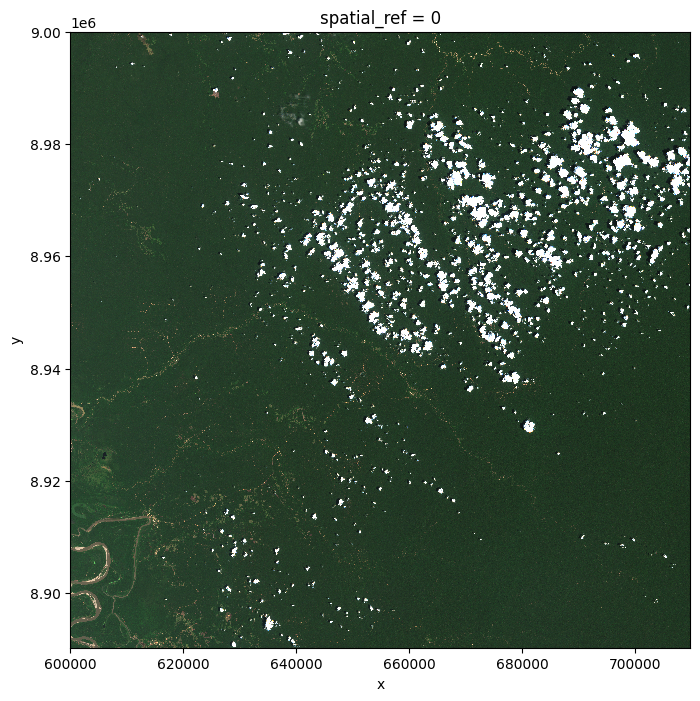

In [23]:
mosaic_visual = rioxarray.open_rasterio(items[8].assets["visual"].href)
mosaic_visual.plot.imshow(figsize=(8,8))

In [20]:
# Load 10 raster images
images = []
dates = []
start = 0

for item in items[start:start+10]:
    image = rasterio.open(item.assets["visual"].href)
    images.append(image)
    dates.append(item.datetime.strftime("%Y/%m/%d").replace('/','-'))


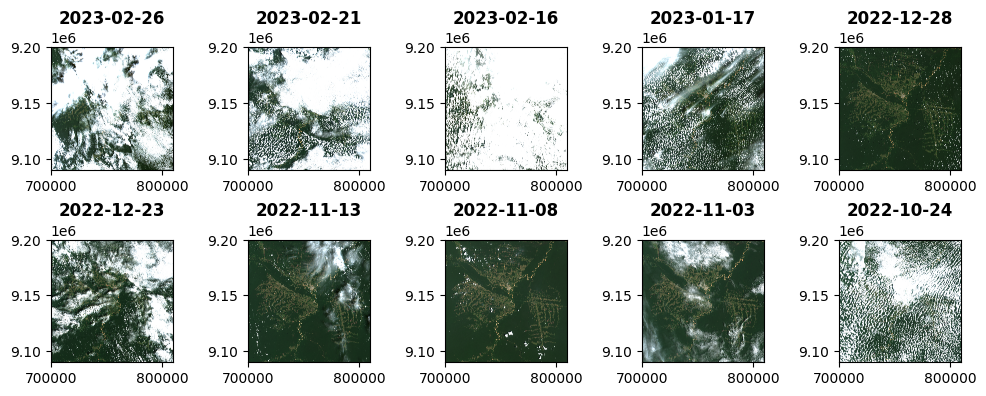

In [21]:



# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))

# Plot each image in a subplot
for i, ax in enumerate(axes.flat):
    show(images[i], ax=ax, title=dates[i])
#     ax.imshow(images[i], cmap='gray')
#     ax.set_title(dates[i])
#     ax.axis('off')

# Adjust subplot spacing
fig.tight_layout()

# Show the plot
plt.show()


# fig, (axr, axg, axb) = pyplot.subplots(1,3, figsize=(21,7))

# show((src, 1), ax=axr, cmap='Reds', title='red channel')
# <matplotlib.axes._subplots.AxesSubplot object at 0x...>

# show((src, 2), ax=axg, cmap='Greens', title='green channel')
# <matplotlib.axes._subplots.AxesSubplot object at 0x...>

# show((src, 3), ax=axb, cmap='Blues', title='blue channel')
# <matplotlib.axes._subplots.AxesSubplot object at 0x...>

# pyplot.show()


In [28]:
len(items[2:12])

10

# SAVE TIF


In [29]:
items[8].assets["visual"].href

'https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/18/L/XQ/2022/11/S2A_18LXQ_20221108_0_L2A/TCI.tif'

In [22]:
image_url = "https://sentinel-cogs.s3.us-west-2.amazonaws.com/sentinel-s2-l2a-cogs/32/T/MT/2023/2/S2B_32TMT_20230220_0_L2A/TCI.tif"
image_url = items[6].assets["visual"].href

with rasterio.Env(
    AWS_NO_SIGN_REQUEST="YES",
    AWS_REGIONAL_ENDPOINTS="FALSE",
    GDAL_DISABLE_READDIR_ON_OPEN="EMPTY_DIR",
):
    with rasterio.open(image_url, session=AWSSession()) as src:
        profile = src.profile
        # Create a new profile with the "tiled" and "blockxsize" options set
        profile.update(
            tiled=True,
            blockxsize=256,
            blockysize=256,
            compress="deflate",
            predictor=2,
        )
        # Define the output filename and open the output file for writing
        output_file = "Luzeiro_50_cloud.tif"
        with rasterio.open(output_file, "w", **profile) as dst:
            # Copy the input data to the output file, block by block
            for ji, window in src.block_windows():
                data = src.read(window=window)
                dst.write(data, window=window)
            # Add overviews to the output file
            dst.build_overviews([2, 4, 8, 16])

2023-03-16 10:13:47.819 WARNING rasterio._env: CPLE_NotSupported in driver GTiff does not support open option SESSION
